# Predicting Airbnb Listing Prices in Taipei
In this project, I will build a model to predict the price of given Airbnb listings in Taipei by using various statistical analysis skills and multiple machine learning algorithms.

The dataset for this project originates from [Inside Airbnb](http://insideairbnb.com/get-the-data.html) and was complied at 2020/6/29, containing 8103 rows of listings and 103 features. Kindly note that I won't put the dataset on my repository because it exceeds the maximum file-size regulated by Github. Click [here](http://data.insideairbnb.com/taiwan/northern-taiwan/taipei/2020-06-29/data/listings.csv.gz) to download the whole dataset. 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
from datetime import date
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# model
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In this session, I declare some useful functions for file-loading and data-processing inspired by Data Exploration phases.

In [3]:
def prepare_data(file_path, index_name):
    data = pd.read_csv(file_path, index_col=index_name)
    return data

def clean_data(data):
    # 1. drop columns
    # neighbourhood_group_cleansed 全部都是空值，因此刪除
    # requires_license 全部都是f，因此刪除
    for drop_col_name in ['neighbourhood_group_cleansed', 'requires_license']:
        data.drop(columns=drop_col_name, inplace=True)
    
    # 2. convert datatype
    # 2.1 converted the date to datetime format.
    # special date format
    data['scrape_id'] = pd.to_datetime(data['scrape_id'], format='%Y%m%d%H%M%S')
    # normal date format
    for date_col_name in ['last_scraped','host_since','calendar_last_scraped','first_review','last_review']:
        data[date_col_name] = pd.to_datetime(data[date_col_name])
    # 2.2 removed the dollar sign from the price
    for price_col_name in ['price','security_deposit','cleaning_fee', 'monthly_price', 'extra_people']:
        data[price_col_name] = data[price_col_name].str.replace('$', '').str.replace(',', '')
        data[price_col_name] = data[price_col_name].astype(float)
    # 2.3 removed the percentagesign from the rate
    for rate_col_name in ['host_response_rate','host_acceptance_rate']:
        data[rate_col_name] = data[rate_col_name].str.replace('%', '').str.replace(',', '')
        data[rate_col_name] = data[rate_col_name].astype(float)

    # 2.4 converted the values of t,f to 1,0 
    for ft_col_name in ['require_guest_phone_verification','require_guest_profile_picture','is_business_travel_ready','instant_bookable','has_availability','is_location_exact','host_identity_verified','host_has_profile_pic','host_is_superhost']:
        data[ft_col_name] = data[ft_col_name].map(lambda x: 1 if x == 't' else 0)
    
    # 3. used mode for filling missing categorical data
    #    used median for filling  missing numerical data
    num_cols = data.describe().columns
    cat_cols = data.select_dtypes(include='object').columns
    data[cat_cols] = data[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))
    data[num_cols] = data[num_cols].apply(lambda col: col.fillna(col.median()))  
    return data

def get_cleaned_dataset(file_path, index_name):
    data = prepare_data(file_path, index_name)
    data = clean_data(data)
    return data

# Feature Engineer Function
def transform_data(data):
    num_cols = data.describe().columns.tolist()
    cat_cols = data.select_dtypes(include='object').columns
    transformed_df = data.copy()

    for col in cat_cols:
        transformed_df[col] = transformed_df[col].astype('category')
        transformed_df = pd.concat([transformed_df.drop(
            col, axis=1), pd.get_dummies(transformed_df[col], prefix=col)], axis=1)
    transformed_df[num_cols] = transformed_df[num_cols].apply(lambda x: np.log(x+1))

    num_cols.remove('price')
    scaler = MinMaxScaler()
    transformed_df[num_cols] = scaler.fit_transform(transformed_df[num_cols])
    return transformed_df

def get_outlier_indexs(data_clean):
    data = data_clean.copy()
    
    # find the outliers of price_log
    data['price_log'] = data['price'].apply(lambda x: np.log(x+1))
    q25, q50, q75 = data['price_log'].quantile(0.25), data['price_log'].quantile(0.5), data['price_log'].quantile(0.75)
    upper_bound, lower_bound = q75+1.5*(q75-q25), q25-1.5*(q75-q25)
    outliers = data[(data.price_log > upper_bound) | (data.price_log < lower_bound)]
    
    print('Number of outliers have been removed: %s' % len(outliers))
    return outliers.index

def get_column_name_to_drop():
    # host_total_listings_count & host_listings_count 相關係數為 1 因此只保留其一
    # calculated_host_listings_count & host_listings_count 相關係數為 0.9 因此只保留其一
    return ['host_total_listings_count', 'calculated_host_listings_count']

------------

## 1. Dataset Loading & Cleaning
Let's start with loading the original dataset `listings.csv` and performing data cleaning tasks. I pick up certain features for the following Data Exploration and Model Development phases. 

In [4]:
listings_file_path = 'dataset/listings.csv'
index_name= 'id'
features = ['cancellation_policy', 'is_location_exact', 'accommodates', 'reviews_per_month', 'property_type', 'price',
            'extra_people', 'calculated_host_listings_count', 'guests_included',
            'review_scores_rating', 'host_response_time', 'number_of_reviews', 'host_is_superhost', 'room_type',
            'instant_bookable', 'amenities', 'host_identity_verified', 'host_has_profile_pic', 'security_deposit',
            'host_total_listings_count', 'host_listings_count', 'neighbourhood_cleansed',
            'minimum_nights', 'bathrooms', 'require_guest_phone_verification', 'cleaning_fee']

listings_dataset = get_cleaned_dataset(listings_file_path, index_name)
data_clean = listings_dataset[features]
data_clean.head(2)

,cancellation_policy,is_location_exact,accommodates,reviews_per_month,property_type,price,extra_people,calculated_host_listings_count,guests_included,review_scores_rating,...,host_identity_verified,host_has_profile_pic,security_deposit,host_total_listings_count,host_listings_count,neighbourhood_cleansed,minimum_nights,bathrooms,require_guest_phone_verification,cleaning_fee
id,,,,,,,,,,,,,,,,,,,,,
74641,strict_14_with_grace_period,1,3,0.47,Guest suite,1474.0,236.0,4,1,88.0,...,1,1,2949.0,4,4,松山區,3,1.0,0,354.0
74643,strict_14_with_grace_period,1,2,0.46,Guest suite,1238.0,236.0,4,1,94.0,...,1,1,2949.0,4,4,松山區,3,1.5,0,354.0


## 2. Data Exploration
### (1) The Distribution of Price & Log(Price)
The distribution of prices is extremely right-skewness as shown in the left chart `The distribution of Prices`. This is not good for prediction models so I apply log transformation on feature `price`. The distribution gets close to normal distribution after the transformation as shown in the right chart `The distribution of Log(Price)`.

**ACTION-ITEM:** Predict log(price), not price.

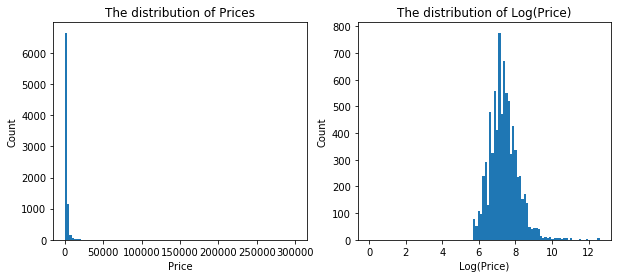

In [5]:
data_clean_eda = data_clean.copy()
data_clean_eda['price_log'] = data_clean_eda['price'].apply(lambda x: np.log(x+1))
n_bins = 100
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('The distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.hist(data_clean_eda['price'], bins=n_bins)

plt.subplot(1, 2, 2)
plt.title('Log(Price)')
plt.title('The distribution of Log(Price)')
plt.xlabel('Log(Price)')
plt.ylabel('Count')
plt.hist(data_clean_eda['price_log'], bins=n_bins)

plt.show()

### (2) The Box-Plot of Log(Price)
I detect the outliers of prices by plotting box-plot. Most of the outliers are on the right side of the box, which means their prices are extremely high. Two outliers are on the left side of the box, which means their prices are extremely low.

**ACTION-ITEM**: Exclude outliers before training models.

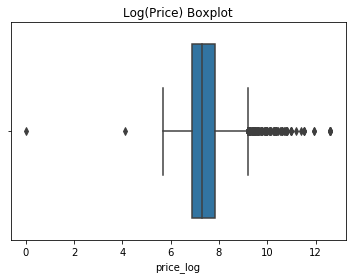

In [6]:
plt.title('Log(Price) Boxplot')
ax = sns.boxplot(x=data_clean_eda['price_log'])

### (3) Correlation Heatmap
After excluding outliers from the dataset, I perform correlation analysis for numerical features.
- Correlation between the target and the features: 
    - target `price` and feature `guests_included`, `accommodates` are medium correlation
- Correlation between piared features: 
    - feature `host_total_listings_count` and featurn `calculated_host_listings_count` is strong correlation
    - feature `host_listings_count` and featurn `calculated_host_listings_count` is strong correlation
    - feature `host_listings_count` and featurn `host_total_listings_count` is absolute correlation
   
**ACTION-ITEM**: To avoid collinearity, keep one feature out of the paired features with strong correlation.

Number of outliers have been removed: 145


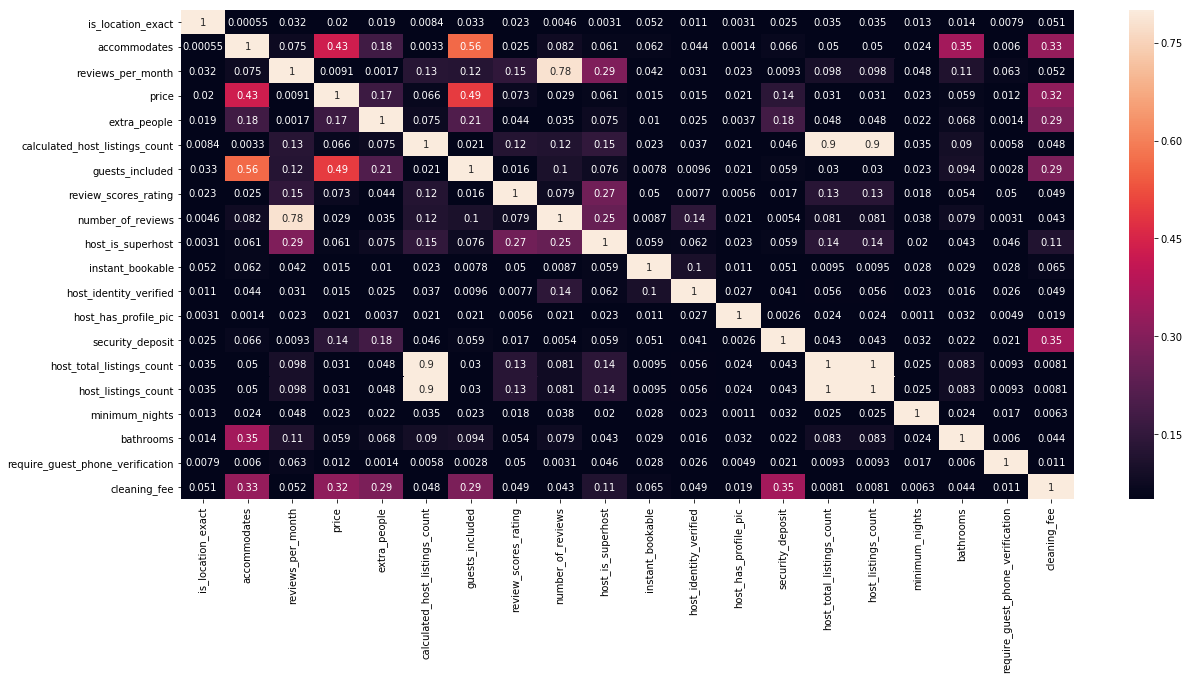

In [9]:
num_cols = data_clean.describe().columns
corr_matrix = data_clean[num_cols].drop(get_outlier_indexs(data_clean)).corr()
corr_matrix = abs(corr_matrix)

f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr_matrix, vmax=0.8, vmin=0.05, annot=True)
plt.show()

In [10]:
corr_matrix['price'].sort_values(ascending=False)

price                               1.000000
guests_included                     0.494829
accommodates                        0.433628
cleaning_fee                        0.319049
extra_people                        0.167367
security_deposit                    0.137227
review_scores_rating                0.072646
calculated_host_listings_count      0.065643
host_is_superhost                   0.060795
bathrooms                           0.059231
host_total_listings_count           0.030745
host_listings_count                 0.030745
number_of_reviews                   0.029157
minimum_nights                      0.022596
host_has_profile_pic                0.021438
is_location_exact                   0.020271
host_identity_verified              0.015484
instant_bookable                    0.014588
require_guest_phone_verification    0.012131
reviews_per_month                   0.009117
Name: price, dtype: float64

## 3. Model Development & Evaluation

First, I declare functions for making charts.

In [20]:
def plot_feature_importances(trained_model, columns):
    model_name = str(trained_model).split('(')[0]
    column_names = out = [name[0:40] for name in columns]
    feat_imp = pd.Series(trained_model.feature_importances_, index=column_names)
    feat_imp.nlargest(15).plot(kind='barh', figsize=(10, 6))
    plt.xlabel('Relative Importance')
    plt.title('Feature importances for '+ model_name, fontsize=16, fontweight='bold')
    plt.show()
    
def plot_predicted_actual_value(trained_model, X_test, y_test):
    model_name = str(trained_model).split('(')[0]
    y_pred = trained_model.predict(X_test) 
    
    pred = np.round(np.exp(y_pred) + 1, 1)
    actual = np.round(np.exp(y_test) + 1, 1)
    
    print('MSE %.3f' % (mean_squared_error(actual, pred)))
    
    plt.figure(figsize=(10, 4))
    plt.scatter(actual.values, pred)
    plt.title('Predicted vs. Actual Price for ' + model_name, fontsize=16, fontweight='bold')
    plt.xlabel('Actual Listing Price')
    plt.ylabel('Predicted Listing Price')
    
    x_coordinates=[0,actual.values.max()]
    y_coordinates=[0,actual.values.max()]
    plt.plot(x_coordinates, y_coordinates, color='red')
    plt.show()

### (1) Find the best model for each candidate algorithm
Given candidate algorithms and respective hyperparameters, I use **Grid Search** and **Cross-Validation** to find the optimal model for price prediction. 

Here is the information about model training:
- Data processing and transformation:
    - Numerical features: MinMaxScaler
    - Categorical features: one-hot encoding
    - Outlier removal
    - Columns drop for collinearity issue
- Candidate algorithms: RandomForest, GradientBoosting
- Performance metric: MSE

In [14]:
# get the data gor model-fitting
data = transform_data(data_clean).drop(get_outlier_indexs(data_clean)).drop(columns=get_column_name_to_drop())
target = data['price']
features = data.drop('price', axis=1)

# split data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=0)

# candidate algorithms
regressors = [
    DummyRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

# candidate parameters
parameters = [
    {'strategy': ['mean', 'median']},
    {'n_estimators': [100, 200, 300], 'max_depth' : [80, 90, 100]},
    {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.3], 'max_leaf_nodes': [8, 16, 24]}
]

# to keep the best estimator after GridSearchCV for each candidate algorithms
best_models = {}

# start to train
for (regressor, tuned_parameters) in zip(regressors, parameters):
    clf = GridSearchCV(regressor, tuned_parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    best_models[(str(regressor).split('(')[0])] = {
        'best_model': clf.best_estimator_,
        'column_names': X_train.columns
    }
    print("%s score: " % (str(regressor).split('(')[0]))
    print('--------------------------')
    print("Best parameters set found on training dataset:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on validation dataset:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print('MSE of log prices %.3f on testing dataset' % (mean_squared_error(y_true, y_pred)))
    pred = np.round(np.exp(y_pred) + 1, 1)
    actual = np.round(np.exp(y_true) + 1, 1)
    print('MSE of original prices %.3f on testing dataset' % (mean_squared_error(actual, pred)))
    print()
    print()

Number of outliers have been removed: 145
DummyRegressor score: 
--------------------------
Best parameters set found on training dataset:

{'strategy': 'mean'}

Grid scores on validation dataset:
-0.466 (+/-0.032) for {'strategy': 'mean'}
-0.466 (+/-0.033) for {'strategy': 'median'}

MSE of log prices 0.463 on testing dataset
MSE of original prices 2118849.939 on testing dataset


RandomForestRegressor score: 
--------------------------
Best parameters set found on training dataset:

{'max_depth': 90, 'n_estimators': 300}

Grid scores on validation dataset:
-0.149 (+/-0.016) for {'max_depth': 80, 'n_estimators': 100}
-0.148 (+/-0.014) for {'max_depth': 80, 'n_estimators': 200}
-0.148 (+/-0.016) for {'max_depth': 80, 'n_estimators': 300}
-0.148 (+/-0.015) for {'max_depth': 90, 'n_estimators': 100}
-0.148 (+/-0.015) for {'max_depth': 90, 'n_estimators': 200}
-0.147 (+/-0.015) for {'max_depth': 90, 'n_estimators': 300}
-0.148 (+/-0.014) for {'max_depth': 100, 'n_estimators': 100}
-0.148 

After a while of training time, I get the report of the performance of each model and identify Gradient Boosting Regressor as the optimal model.

**Optimal model**: GradientBoostingRegressor with parameters {'learning_rate': 0.3, 'max_leaf_nodes': 16, 'n_estimators': 300}

### (2) Feature importances
For the optimal model, top 3 important features are `extra_people`, `guests_included` and `accommodates`. It seems reasonable because the higher-priced listing has more space to accommodate more people.

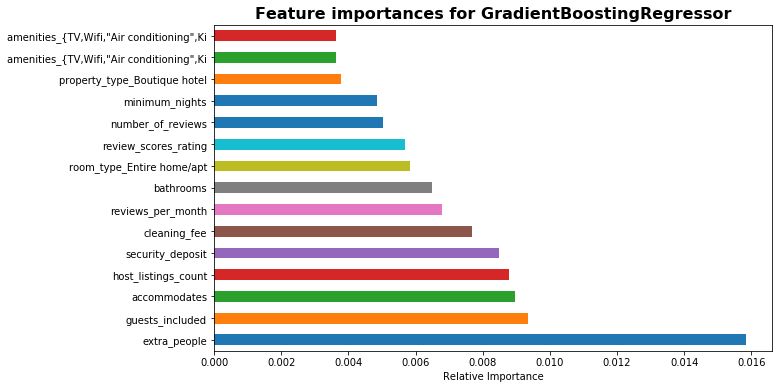

In [21]:
best_model = best_models.get('GradientBoostingRegressor')
plot_feature_importances(best_model.get('best_model'), best_model.get('column_names'))

### (3) The scatter plot of predicted vs. actual price
I create a plot to show the relation between actual prices and predicted prices generated by the optimal model. The listings with actual prices greater than 4000 have larger residuals. The predicted prices are underestimated.

MSE 817083.128


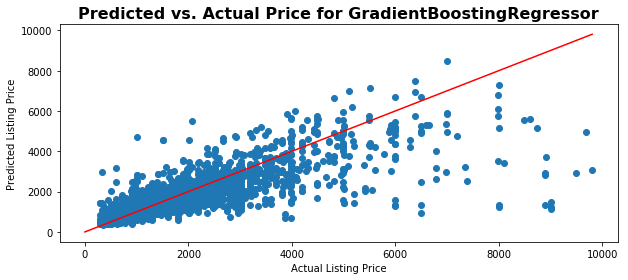

In [17]:
plot_predicted_actual_value(best_model.get('best_model'),  X_test, y_test)

------
This finishes the project. I have built a gradient boosting regressor that predicts listing prices in Taipei. In addition, to further improve the accuracy of the model, I could try something like:
- decreasing the residual of listings with prices greater than 4000 by performing analysis to get deeper insights
- changing the target variable from `price` to `price+clean_fee` so that the prediction of listing value based on listing properties can be more exact